# Bootstraping no Pandas

Esse notebook tem como objetivo ilustrar um exemplo de como a técnica de bootstraping pode ser empregada utilizando a biblioteca `Pandas`.

---

## Pré-processamento:

Lendo e padronizando os dados:

In [3]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

iris = load_iris() # variável iris será do tipo bunch
dados = iris.data
alvo = iris.target



Transformando o dataset do formato `sklearn.utils.Bunch` para `pandas.DataFrame`:

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2.0
146,6.3,2.5,5.0,1.9,2.0
147,6.5,3.0,5.2,2.0,2.0
148,6.2,3.4,5.4,2.3,2.0


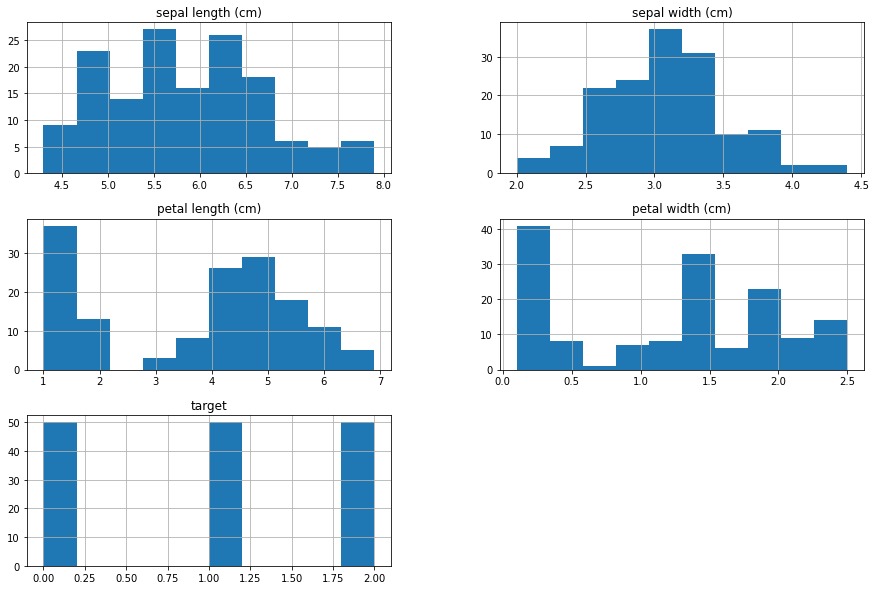

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

df = pd.DataFrame(data=np.c_[dados, alvo], columns= iris['feature_names'] + ['target'])

plt.rcParams['figure.figsize'] = [15, 10]
_ = df.hist()

df

Transformando o dataset em um problema binário (ao invés de termos classes tipo 0, tipo 1 e tipo 2, teremos as classes tipo 1 e tipo não 1). Para isso vamos substituir todas as ocorrências da classe 2 para classe 0:

0.0    100
1.0     50
Name: target, dtype: int64

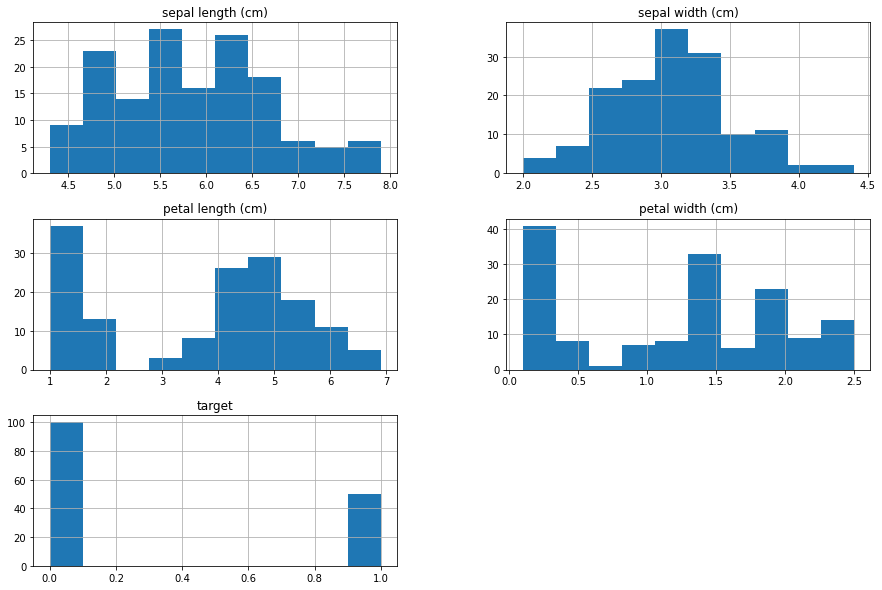

In [5]:
df.target = df.target.replace(to_replace = 2, value = 0)
_ = df.hist()
df['target'].value_counts()



---

## Cálculo de acurácia com e sem  Bootstraping

Vamos utilizar um algoritmo de classificação simples, o KNN para K=5:

In [6]:
from sklearn.neighbors import KNeighborsClassifier

_5nn = KNeighborsClassifier(n_neighbors=5)

Separarando os dados em 80% treino e 20% teste utilizando `train_test_split` e criando um novo dataframe só de instancias de treino, para facilitar o manuseio:

0.0    80
1.0    40
Name: target, dtype: int64

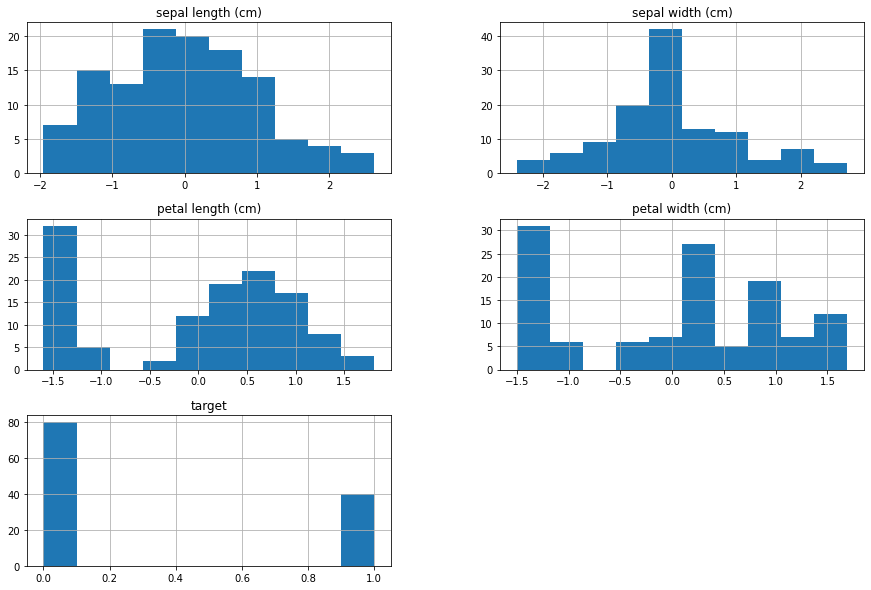

In [7]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split

p_treino = 0.8
p_teste = 1 - p_treino

X = df.iloc[:, 0:4]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=p_teste, random_state=2)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

data_train = pd.DataFrame(data=np.c_[X_train, y_train], columns= iris['feature_names'] + ['target'])
_ = data_train.hist()
data_train['target'].value_counts()

Balanceando as classes no conj. de treino

In [8]:
classe_0 = data_train[data_train['target'] == 0]
classe_1 = data_train[data_train['target'] == 1]
data_train = pd.concat([classe_0, classe_1.sample(n=80, replace=True)])

X_train, y_train = data_train.iloc[:, 0:4], data_train.iloc[:, -1]

data_train['target'].value_counts()


0.0    80
1.0    80
Name: target, dtype: int64

Calculando acurácia:

In [9]:
_5nn.fit(X_train, y_train)  
y_pred = _5nn.predict(X_test)
acc = balanced_accuracy_score(y_test, y_pred)
print("Acurácia do classificador na amostra: %.2f%%" % (acc*100))

Acurácia do classificador na amostra: 90.00%


Será que a acurácia real do modelo é realmente essa? 

Vamos verificar utilizando Bootstrap de tamanho 1000:

In [10]:
no_exemplos = df.shape[0]
p_treino = 0.8
p_teste = 1 - p_treino
no_bootstrap = 1000

scores = []
for i in range(0, no_bootstrap):
    amostra = df.sample(n = no_exemplos, replace=True) # Obtendo amostra do bootstrap

    X = amostra.iloc[:, 0:4] # Separando em dados 
    y = amostra.iloc[:, -1]  # e variável alvo

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=p_teste) # Split dos dados de maneira estratificada (mantendo prop. das classes)
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)

    data_train = pd.DataFrame(data=np.c_[X_train, y_train], columns= iris['feature_names'] + ['target']) # Criando um dataframe com os dados de treino
    classe_0 = data_train[data_train['target'] == 0]
    classe_1 = data_train[data_train['target'] == 1]
    n_elementos_classe_0 = data_train['target'].value_counts()[0] # Coletando o número de exemplos da classe 0 para superamostragem da classe 1  
    data_train = pd.concat([classe_0, classe_1.sample(n=n_elementos_classe_0, replace=True)]) # Superamostragem da classe 1 para numero de elementos da classe 0

    X_train, y_train = data_train.iloc[:, 0:4], data_train.iloc[:, -1] # reatribuição dos dados pra treino (agora superamostrados)

    _5nn.fit(X_train, y_train)  
    y_pred = _5nn.predict(X_test)
    scores.append(balanced_accuracy_score(y_test, y_pred))

print("Score do classificador utilizando Bootstrap de tamanho %d: %.2f%%" % (no_bootstrap, np.mean(scores)*100))

Score do classificador utilizando Bootstrap de tamanho 1000: 95.07%


Com o bootstrap verificamos que na verdade a acurácia real tende ao valor 95.1%.



---

## Matriz de confusão:

Podemos calcular a matriz de confusão para cada fold, e soma-las para obter a matriz de confusão da operação de bootstrap:

Score do classificador utilizando Bootstrap de tamanho 1000: 95.04%
Matriz de confusão:
[[18767  1238]
 [  372  9623]]


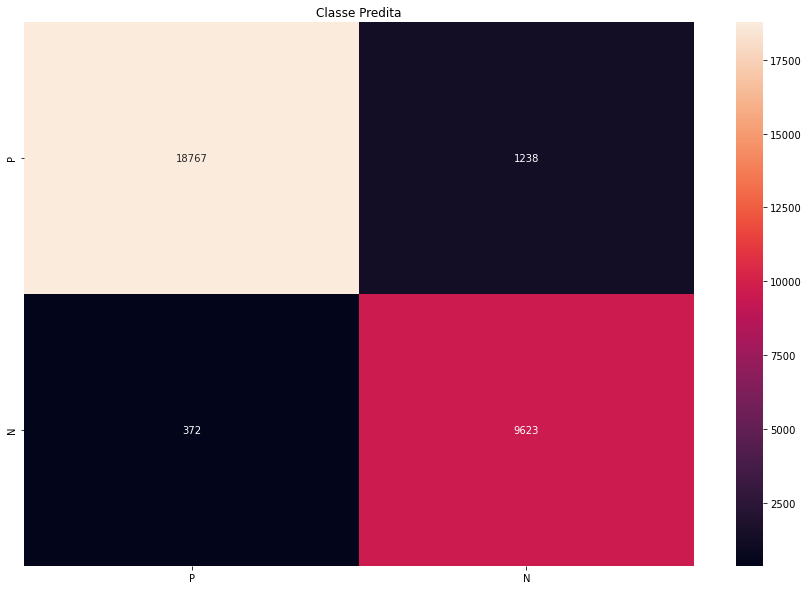

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

no_exemplos = df.shape[0]
p_treino = 0.8
no_bootstrap = 1000

matriz_conf = np.array([[0,0], [0,0]])

scores = []
for i in range(0, no_bootstrap):
    amostra = df.sample(n = no_exemplos, replace=True) # Obtendo amostra

    X = amostra.iloc[:, 0:4]
    y = amostra.iloc[:, -1]

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=p_teste)
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)

    data_train = pd.DataFrame(data=np.c_[X_train, y_train], columns= iris['feature_names'] + ['target'])
    classe_0 = data_train[data_train['target'] == 0]
    classe_1 = data_train[data_train['target'] == 1]

    # Coletando o número de exemplos da classe 0 para superamostragem da classe 1  
    n_elementos_classe_0 = data_train['target'].value_counts()[0] 
    # Superamostragem da classe 1 para numero de elementos da classe 0
    data_train = pd.concat([classe_0, classe_1.sample(n=n_elementos_classe_0, replace=True)])

    X_train, y_train = data_train.iloc[:, 0:4], data_train.iloc[:, -1]

    _5nn.fit(X_train, y_train)
    y_pred = _5nn.predict(X_test)
    scores.append(balanced_accuracy_score(y_test, y_pred))
    matriz_conf += confusion_matrix(y_test, y_pred, labels=[0, 1])

print("Score do classificador utilizando Bootstrap de tamanho %d: %.2f%%" % (no_bootstrap, np.mean(scores)*100))
print("Matriz de confusão:")
print(matriz_conf)

sns.heatmap(matriz_conf, annot=True, fmt='d', xticklabels=['P','N'], yticklabels=['P','N']).set_title('Classe Predita')
plt.show()

In [12]:
vp, vn, fp, fn = matriz_conf[0,0],matriz_conf[1,1],matriz_conf[1,0],matriz_conf[0,1]

# Sensibilidade ou Revocação (Recall)
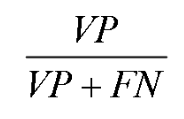

In [13]:
# No Scikit -> sklearn.metrics.recall_score
recall = vp / (vp+fn)
print(recall) 

0.9381154711322169


# Especificidade ou Precisão (Precision)

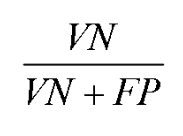

In [14]:
# No Scikit -> sklearn.metrics.precision_score
precision = vn / (vn+fp)
print(precision)

0.9627813906953476


# Acurácia

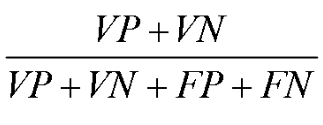

In [15]:
# No Scikit -> sklearn.metrics.accuracy_score
acc = (vp+vn) / (vp+vn+fp+fn)
print(acc)

0.9463333333333334


# F1-Score

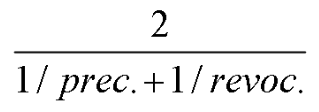

In [16]:
# No Scikit -> sklearn.metrics.f1_score
f1 = 2 * (precision*recall) / (precision + recall)
print(f1)

0.9502883991939892
